# Assignment <span style="color:red">option Four</span> - News Categorization  using PyTorch 
Download the dataset from https://www.kaggle.com/uciml/news-aggregator-dataset and develop a news classification or categorization model. The dataset contain only titles of a news item and some metadata. The categories of the news items include one of: –<span  style="color:red"> b</span> : business – <span  style="color:red">t</span> : science and technology – <span  style="color:red">e</span> : entertainment and –<span  style="color:red">m</span> : health. 

1. Prepare training and test dataset: Split the data into training and test set (80% train and 20% test). Make sure they are balanced, otherwise if all <span  style="color:red">b</span> files are on training, your model fails to predict <span  style="color:red">t</span> files in test.
2. Binary classification: produce training data for each two categories, such as <span  style="color:red">b </span> and <span  style="color:red"> t</span>, <span  style="color:red">b</span> and <span  style="color:red"> m</span>, <span  style="color:red">e</span> and <span  style="color:red">t</span> and so on. Evaluate the performance and report which categories are easier for the models.
3. Adapt the Text Categorization PyTorch code (see above) and evaluate the performance of the system for these task
4. Use a pre-trained embeddings and compare your result. When you use pre-ttrained mebeddings, you have to average the word embeddings of each tokens in ach document to get the unique representation of the document. DOC_EMBEDDING = (TOKEN1_EMBEDDING + ... + TOKENn_EMBEDDING). You can also use some of the <span  style="color:red">spacy/FLAIR </span>document embedding methods
6. Report the recall, precision, and F1 scores for both binary and multi-class classification.
 

# Binary classification (b and t) (NOT PRETRAINED)

#### In this notebook we train the model on a integer sequence based on the tokens (NOT PRETRAINED). 

In [1]:
import pandas as pd
from collections import Counter

df = pd.read_csv('uci-news-aggregator.csv')

del df['URL']
del df['PUBLISHER']
del df['STORY']
del df['HOSTNAME']
del df['TIMESTAMP']
del df['ID']

In [2]:
df.CATEGORY.replace('b','business', inplace=True)
df.CATEGORY.replace('t','science and technology', inplace=True)
df.CATEGORY.replace('e','entertainment', inplace=True)
df.CATEGORY.replace('m','health', inplace=True)

In [3]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
labels = lb_make.fit_transform(df.CATEGORY)

In [4]:
df['labels'] = labels

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

train, test =  train_test_split(df, test_size=0.20, random_state=42)

In [6]:
train.CATEGORY.value_counts()

entertainment             122116
business                   92553
science and technology     86651
health                     36615
Name: CATEGORY, dtype: int64

In [7]:
test.labels.value_counts()

1    30353
0    23414
3    21693
2     9024
Name: labels, dtype: int64

### Because of memory issues we define 70000 as the maximum number of words considered

In [ ]:
#!pip install tensorflow
import tensorflow as tf
tf.config.run_functions_eagerly(False)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# The maximum number of most frequent words to be used.
MAX_NB_WORDS = 10000 # TODO: Check if still correct
# Max number of words in each row
MAX_SEQUENCE_LENGTH = 150

print("Doing...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(df['TITLE'].values)
word2index = tokenizer.word_index
print('Found %s unique tokens.' % len(word2index))

In [9]:
from keras.preprocessing.text import text_to_word_sequence

def get_batch(df,i,batch_size):
    batches = []
    results = []
    texts = df.TITLE[i*batch_size:i*batch_size+batch_size]
    categories = df.labels[i*batch_size:i*batch_size+batch_size]
    
    for text in texts:
        layer = np.zeros(total_words,dtype=float)

        for word in text_to_word_sequence(text):
            word2index[word.lower()]
            layer[word2index[word.lower()]] += 1
        batches.append(layer)

    for category in categories:
        index_y = -1
        if category == 0:
            index_y = 0
        elif category == 1:
            index_y = 1
        elif category == 2:
            index_y = 2
        else:
            index_y = 3
        results.append(index_y)

    return np.array(batches),np.array(results)

In [43]:
def pad_sequence(texts):
    batches = []
    for text in texts:
        layer = np.zeros(total_words,dtype=float)

        for word in text_to_word_sequence(text):
            try:
                word2index[word.lower()]
                layer[word2index[word.lower()]] += 1
            except:
                print("word is not included")            
        batches.append(layer)
    
    return batches

In [11]:
import torch.nn as nn
import torch

learning_rate = 0.1
num_epochs = 3 # TODO: check if more is better?
batch_size = 2000
display_step = 1
total_words = len(word2index)
hidden_size = 64 
input_size = total_words
num_classes = 4 # TODO: reduce to two

class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ANN, self).__init__()
        self.layer_1 = nn.Linear(input_size,hidden_size, bias=True)
        self.relu = nn.ReLU()
        self.layer_2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear(hidden_size, num_classes, bias=True)

    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.output_layer(out)
        return out

##### We could observe that the loss is not decreasing under 0.08. Therefore, we earlystop after 3 Epochs

In [12]:
model = ANN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

for epoch in range(num_epochs):
    total_batch = int(len(train.TITLE)/batch_size)
    for i in range(total_batch):
        batch_x,batch_y = get_batch(train,i,batch_size)
        articles = torch.FloatTensor(batch_x)
        labels = torch.LongTensor(batch_y)

        optimizer.zero_grad()
        outputs = model(articles)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 4 == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, 
                     len(train.TITLE)/batch_size, loss.data))

C:\Users\PCOvice\anaconda3\lib\site-packages\torch\autograd\__init__.py:147: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(


Epoch [1/3], Step [4/168], Loss: 0.9402
Epoch [1/3], Step [8/168], Loss: 0.6029
Epoch [1/3], Step [12/168], Loss: 0.4921
Epoch [1/3], Step [16/168], Loss: 0.3996
Epoch [1/3], Step [20/168], Loss: 0.3735
Epoch [1/3], Step [24/168], Loss: 0.3821
Epoch [1/3], Step [28/168], Loss: 0.3073
Epoch [1/3], Step [32/168], Loss: 0.2900
Epoch [1/3], Step [36/168], Loss: 0.2545
Epoch [1/3], Step [40/168], Loss: 0.2368
Epoch [1/3], Step [44/168], Loss: 0.2411
Epoch [1/3], Step [48/168], Loss: 0.2204
Epoch [1/3], Step [52/168], Loss: 0.2013
Epoch [1/3], Step [56/168], Loss: 0.2035
Epoch [1/3], Step [60/168], Loss: 0.2273
Epoch [1/3], Step [64/168], Loss: 0.2265
Epoch [1/3], Step [68/168], Loss: 0.2098
Epoch [1/3], Step [72/168], Loss: 0.1923
Epoch [1/3], Step [76/168], Loss: 0.2009
Epoch [1/3], Step [80/168], Loss: 0.1953
Epoch [1/3], Step [84/168], Loss: 0.2218
Epoch [1/3], Step [88/168], Loss: 0.1799
Epoch [1/3], Step [92/168], Loss: 0.1940
Epoch [1/3], Step [96/168], Loss: 0.1883
Epoch [1/3], Step 

In [61]:
#torch.save(ANN.state_dict(input_size, hidden_size, num_classes), 'mode.pth')

# model = ANN(input_size, hidden_size, num_classes)
# model.load_state_dict(torch.load('mode.pth'))
# model.eval()

## Divide and conquer

Our dataset is huge and so is our dimension. Therefore, we use the divide and conquer approach, because we do not have enough memory to allocate the amount of data as numpy arrays


##### note: this can take a little bit time

In [22]:
from tqdm import tqdm

def div_and_conq(texts):
    preds = []
    texts = list(texts)
    
    for i in tqdm(range(len(texts))):
        padded_text = pad_sequence([texts[i]])
        torch_pad_text = torch.FloatTensor(padded_text)
        output = model(torch_pad_text)
        _, pred = torch.max(output.data, 1)
        preds.extend(pred)
        
    return preds

In [52]:
X_test = div_and_conq(test.TITLE)
Y_test = test.labels

 65%|████████████████████████████████████████████████▍                          | 54587/84484 [06:51<03:42, 134.25it/s]

word is not included


100%|███████████████████████████████████████████████████████████████████████████| 84484/84484 [10:40<00:00, 131.95it/s]


In [67]:
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

acc_score = round(100*accuracy_score(X_test,Y_test),4)

print(f"Model accuracy is {acc_score} %")

Model accuracy is 93.9527 %


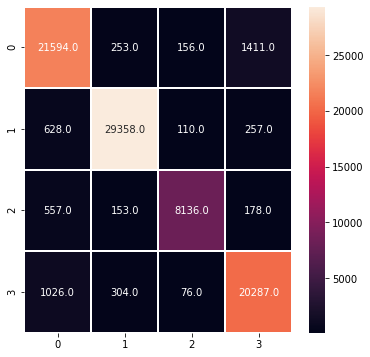

In [68]:
confusion_matrix = confusion_matrix(y_pred=X_test,y_true=Y_test)

fig,ax = plt.subplots(figsize=(6,6))
sns.heatmap(confusion_matrix,annot=True,fmt="0.1f",linewidths=1.5)
plt.show()

In [71]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, _ = score(Y_test,X_test)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('f1score: {}'.format(fscore))

precision: [0.90712035 0.97638686 0.9596603  0.91659513]
recall: [0.92226873 0.96721906 0.90159574 0.93518647]
f1score: [0.91463182 0.97178133 0.92972232 0.92579747]
